  age     n  alcohol_use  alcohol_frequency  marijuana_use  \
0  12  2798          3.9                3.0            1.1   
1  13  2757          8.5                6.0            3.4   
2  14  2792         18.1                5.0            8.7   
3  15  2956         29.2                6.0           14.5   
4  16  3058         40.1               10.0           22.5   

   marijuana_frequency  cocaine_use cocaine_frequency  crack_use  \
0                  4.0          0.1               5.0        0.0   
1                 15.0          0.1               1.0        0.0   
2                 24.0          0.1               5.5        0.0   
3                 25.0          0.5               4.0        0.1   
4                 30.0          1.0               7.0        0.0   

  crack_frequency  ...  oxycontin_use oxycontin_frequency  tranquilizer_use  \
0               -  ...            0.1                24.5               0.2   
1             3.0  ...            0.1                41.0   

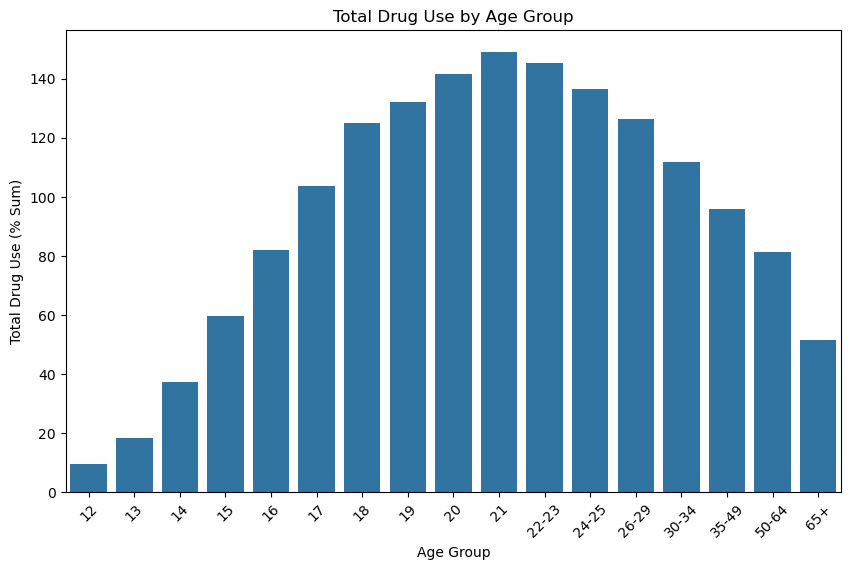

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


df = pd.read_csv('drug-use-by-age.csv')
print(df.head())

# Replace '-' with 0
df = df.replace('-', 0)

# Convert relevant columns to numeric
for col in df.columns:
    if '_use' in col or '_frequency' in col or col == 'n':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Create total_drug_use by summing all '_use' columns
use_columns = [col for col in df.columns if '_use' in col]
print("Columns used for total_drug_use:", use_columns)  # Debug: Verify columns
df['total_drug_use'] = df[use_columns].sum(axis=1)

# Verify the new column
print("DataFrame columns:", df.columns.tolist())  # Debug: Confirm column exists
print(df[['age', 'total_drug_use']].head())  # Debug: Inspect the column

# Plot total drug use by age group
plt.figure(figsize=(10, 6))
sns.barplot(x='age', y='total_drug_use', data=df)
plt.title('Total Drug Use by Age Group')
plt.xticks(rotation=45)
plt.ylabel('Total Drug Use (% Sum)')
plt.xlabel('Age Group')
plt.show()

In [13]:
# Encode age to numeric
age_mapping = {
    '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19,
    '20': 20, '21': 21, '22-23': 22.5, '24-25': 24.5, '26-29': 27.5, '30-34': 32,
    '35-49': 42, '50-64': 57, '65+': 70
}
df['age_numeric'] = df['age'].map(age_mapping)

# Select features and target
feature_cols = ['age_numeric', 'n']
X = df[feature_cols]
y = df['total_drug_use']

# Check for missing values
print("Missing values in X:\n", X.isnull().sum())
print("Missing values in y:", y.isnull().sum())
X = X.fillna(0)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Missing values in X:
 age_numeric    0
n              0
dtype: int64
Missing values in y: 0


In [21]:
#Traing the model
model = LinearRegression()
model.fit(X_train_scaled , y_train)# Generate predictions
y_pred = model.predict(X_test_scaled)



Linear Regression MSE: 5239.19
Linear Regression R²: -2.25


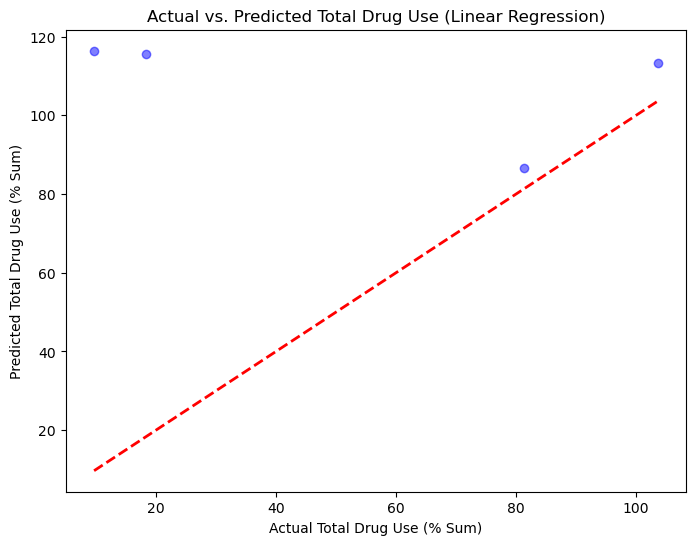

In [23]:
#Evaluate the model 
mse = mean_squared_error(y_test , y_pred)
r2 = r2_score(y_test , y_pred)
print(f'Linear Regression MSE: {mse:.2f}')
print(f'Linear Regression R²: {r2:.2f}')

plt.figure(figsize = (8,6))
plt.scatter(y_test ,y_pred , color = 'blue' ,alpha = 0.5)
plt.plot([y_test.min() , y_test.max()] , [y_test.min() , y_test.max()] ,'r--' ,lw=2)
plt.xlabel('Actual Total Drug Use (% Sum)')
plt.ylabel('Predicted Total Drug Use (% Sum)')
plt.title('Actual vs. Predicted Total Drug Use (Linear Regression)')
plt.show()


In [31]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state = 42)
rf_model.fit(X_train_scaled , y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
print(f'Random Forest MSE: {mean_squared_error(y_test, y_pred_rf):.2f}')
print(f'Random Forest R²: {r2_score(y_test, y_pred_rf):.2f}')


Random Forest MSE: 680.27
Random Forest R²: 0.58


In [35]:
#Cross Validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f'Cross-Validation R² Scores: {scores}')
print(f'Average CV R²: {scores.mean():.2f} (± {scores.std() * 2:.2f})')

Cross-Validation R² Scores: [ 0.502956    0.74025044 -0.28699671 -2.47018776  0.98902016]
Average CV R²: -0.10 (± 2.52)


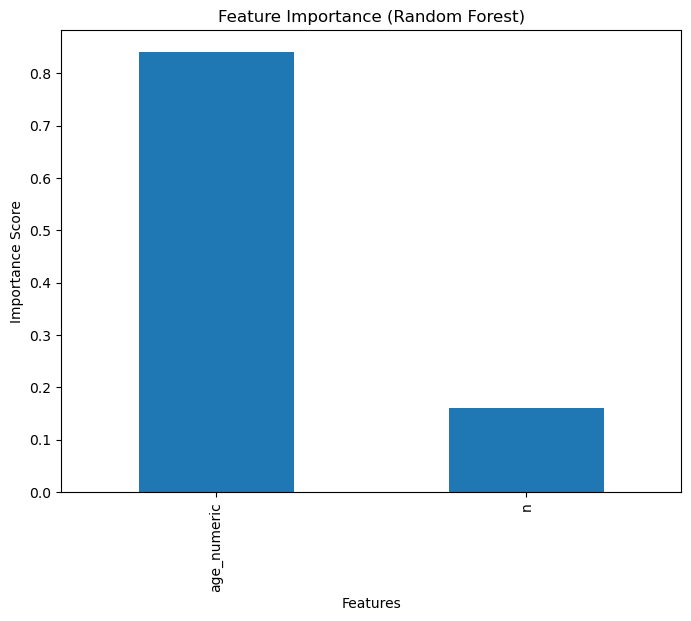

In [39]:
#Freature Importance
importances = rf_model.feature_importances_
feature_importance = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance (Random Forest)')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()

In [41]:
#Save the model 
import joblib
joblib.dump(rf_model, 'total_drug_use_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [ ]:
#Predict on new data:
model = joblib.load('total_drug_use_model.pkl')
scaler = joblib.load('scaler.pkl')
new_data = pd.Dataframe({'age_numeric' : [20] , 'n' : [2000]})
new_Data_scaled = scaler.transform(new_data)
prediction = model.predict(new_data_scaled)
